##Set up environment

In [ ]:
# !pip install scipy.stats
# !pip install datetime
# !pip install numpy
# !pip install pandas
# !pip install matplotlib.pyplot
# !pip install yfinance
# !pip install statistics
# !pip install pandas_datareader

In [ ]:
from math import log, sqrt, pi, exp
from scipy.stats import norm
from datetime import datetime, date
import datetime as dt
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data as pdr
import statistics

##Input Box

In [ ]:
#Here are all the variables that need to be inputted

stock_list = ['AAPL','SPY','NFLX']
#- select n numbers of underlying stock ticker here
#- e.g. TSLA is the stock ticker symbol for Tesla, Inc., and APPL is the the stock ticker symbol for Apple, Inc....
#- stock ticker symbol can be searched on Stock Market Websites: Yahoo Finance (finance.yahoo.com), Google Finance (google.com/finance), or Bloomberg (bloomberg.com), allow investors to search for a company and provide its ticker symbol along with other financial data.

strike_price = [175,427,320]
#- enter strike price of option here, the number of elements in strike_price should match that in stock_list
#- e.g. the strike price of Tesla's option is 360, that of Apple's option is 440...
#- the format is [strike price 1, strike price 2, strike price 3, ..., strike price n ], notice that there's no '' here in the []

stock_in_portfolio = 'GOOG'
#- select a stock that is included in the portfolio

r = 0.05   #enter riskfree rate,

T = 252 #enter expiration date here (calculated in days)

N = 100 #number of steps within each simulation

i = 1000 #number of simulations

stock_weight = 0.3
#- select the weight of stock

option_weight = [0.2,0.3,0.2]
#- e.g. the weight of Tesla's call with strike_price of 155 is 0.2, the weight of Tesla's call with strike_price of 157 is 0.3...
#- the format is [weight 1, weight 2, weight 3,..., weight n], notice that there's no '' here in the []


##Calculate Sigma

In [ ]:
#calculate the volatility of stock
today = datetime.now()
one_year_ago = today.replace(year=today.year-1)

#define a function named get_data:
#- downlaod the Close price of one stock from one year ago to current date.
#- Close price: It is the final price at which the stock was traded before the market closes for the day.
def get_data(stock, one_year_ago, today):
    # Retrieve stock data
    yf.pdr_override()
    df = yf.download(stock, start=one_year_ago, end=today)
    df = df.sort_values(by="Date")
    df = df.dropna()
    df = df.assign(close_day_before=df.Close.shift(1))
    return df

#define a function named calculate_sigma:
#- calculate the annualized volatility of stock by:
#- calculate the daily logarithmic return
#- calculates the standard deviation of the daily returns

def calculate_sigma(stock, one_year_ago, today):
    df = get_data(stock, one_year_ago, today)
    df['returns'] = np.log(df.Close) - np.log(df.close_day_before)
    sigma = df['returns'].std()
    return sigma

#execute function calculate_sigma:
#- print the sigma in for each stock in stock_list
for stock in stock_list:
    sigma = calculate_sigma(stock, one_year_ago, today)
    print(f"Stock: {stock}, daily sigma: {sigma}")

[*********************100%***********************]  1 of 1 completed
Stock: AAPL, daily sigma: 0.020518101578037254
[*********************100%***********************]  1 of 1 completed
Stock: SPY, daily sigma: 0.013743268694156137
[*********************100%***********************]  1 of 1 completed
Stock: NFLX, daily sigma: 0.03150841715813413


In [ ]:
# calculate stock_in_portfolio sigma
sigma_portfolio = calculate_sigma(stock_in_portfolio, one_year_ago, today)
print(f"Stock: {stock_in_portfolio}, daily sigma: {sigma_portfolio}")

[*********************100%***********************]  1 of 1 completed
Stock: GOOG, daily sigma: 0.024456075522270058


##Simulate Stock Price

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
0.020518101578037254


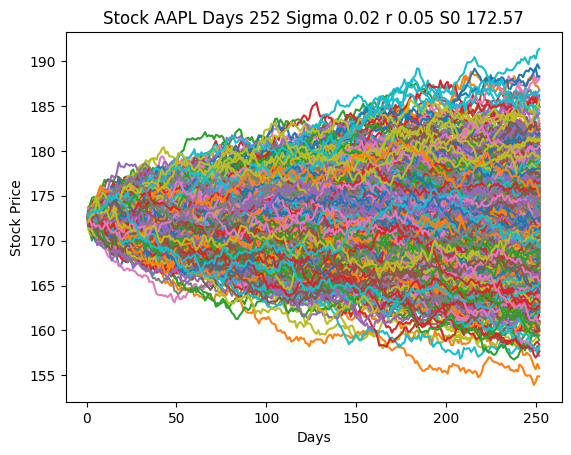

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
0.013743268694156137


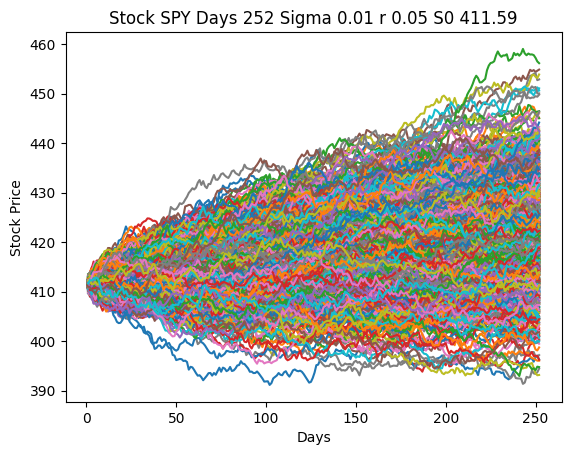

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
0.03150841715813413


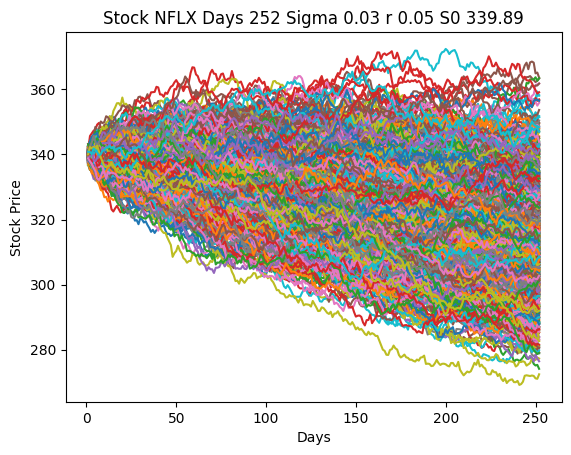

In [ ]:
#define a function named geometric_brownian: performs a Monte Carlo simulation to generate multiple paths of simulated stock prices using the geometric Brownian motion model
#- create 1 empty array "S", with 2 dimensions [i, N]  to store the simulated stock prices. （i and N are defined in the input box）
#- for y in range (0,i-1): the code enters a loop that iterates i-1 times, i-1 represents the number of simulations to be performed.
#- Within the loop, the initial stock price, S0 is set for each simulation. e.g. S[0,0]=S[1,0]=...S[i-1,0]=S0
#- it generates i-1 market senarios
#- for x in range (0,N-1): the code enters a loop that iterates N-1 times, N-1 represents the number of time steps.
#- Within the loop, it calculates the stock price at each time step using the geometric Brownian motion equation
#- store calculated stock prices in the "S" array

def geometric_brownian(S0,T,N,r,sigma,simulation_count=i):
    # matrix store the results
    S = np.zeros([T, simulation_count])

    S0_matrix = np.ones(simulation_count) * S0
    u = r / 252
    delta_t = 1 / N # each step takes 1/N day

    # run simulation N times a day for T days, totally N * T
    for y in range(N * T):
      S0_matrix *= np.exp((u - sigma**2 / 2) * delta_t + sigma * delta_t * np.random.normal(0, 1, size=[simulation_count]))
      if (y + 1) % N == 0: # end of day
        S[y // N, :] = S0_matrix
    return S

#define a function named plot:
#- plot the process of Monte Carlo simulation
def plot(S, T, sigma, r, S0):
    t = range(1, T+1, 1)
    plt.plot(t, S)

    plt.title('Stock %s Days %d Sigma %.2f r %.2f S0 %.2f' % (stock, T, sigma, r, S0))
    plt.xlabel('Days')
    plt.ylabel('Stock Price')
    plt.show()

#execute function get_data, calculate_sigma, geometric_brownian:
#- print the result of monte carlo simulation for every stock in stock_list
#- e.g. The 1st picture is the predicted stock price of Tesla, the 2nd one is that of Apple...

stock_T = np.zeros([i, len(stock_list)], dtype=np.float16) #option price at the end of day T, shape(i * 3)
stock_0 = np.zeros(3, dtype=np.float16)
for j, stock in enumerate(stock_list):
    df = get_data(stock, one_year_ago, today)
    S0 = df.iloc[-1]['Close'] #initial stock price = current Close price
    stock_0[j] = S0
    sigma = calculate_sigma(stock, one_year_ago, today)
    S = geometric_brownian(S0, T, N, r, sigma)
    stock_T[:, j] = S[-1, :]
    print(sigma)
    plot(S, T, sigma, r, S0)
    # print(S[t]) # The 1 dimention array of each stock's price on one path, delete the # before print(C) to see results, maintian the # to hide the result
    # print(S) # The 2 dimention array of each stock's price on all the path, delete the # before print(S) to see results, maintian the # to hide the result


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
0.024456075522270058


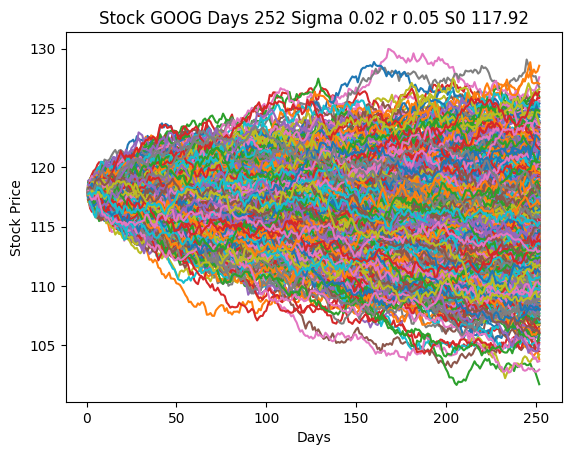

In [ ]:
# stock_in_portflio_price
df = get_data (stock_in_portfolio, one_year_ago, today)
S0 = df.iloc[-1]['Close'] #initial stock price = current Close price
sigma = calculate_sigma(stock_in_portfolio, one_year_ago, today)
S = geometric_brownian(S0, T, N, r, sigma)
stock_price_0 = S0
stock_price_T = np.array(S[-1, :], dtype=np.float16) # stock price at the end of day T
print(sigma)

def plot(S, T, sigma, r, S0):
    t = range(1, T+1, 1)
    plt.plot(t, S)
    plt.title('Stock %s Days %d Sigma %.2f r %.2f S0 %.2f' % (stock_in_portfolio, T, sigma, r, S0))
    plt.xlabel('Days')
    plt.ylabel('Stock Price')
    plt.show()

plot(S, T, sigma, r, S0)


##Get the option price

In [ ]:
# define a function named call:
#- create a 1-dimensional array with i-1 elements to store call price
#- calculate call price by maxmize: (a) stock price in the (N-1)th steps (S[y, N-1]) minus the strike price(K), and (b) zero.
def call(St, strike_price):
  return np.maximum(St - strike_price, 0)

# Calculate the value of the portofolio.
#   stock_price: 1 * i
def calc_portfolio_value(stock_weight, stock_price, option_weight, option_price, r, T, dim=2):
  axis_val = 1 if dim == 2 else 0
  price_sum = stock_weight * stock_price + np.sum(np.array(option_weight) * option_price, axis=axis_val)
  return price_sum / np.exp(r * T / 365)

call_T = call(stock_T, strike_price)
portfolio_value_T = calc_portfolio_value(stock_weight, stock_price_T, option_weight, call_T, r, T)


##Calculate portfolio return and VaR

In [ ]:
call_0 = call(stock_0, strike_price)
print(f"Call value at T = 0 is {call_0}")
portfolio_value_0 = calc_portfolio_value(stock_weight, stock_price_0, option_weight, call_0, r, T, dim=1)
print(f"The portfolio value at T = 0 is {portfolio_value_0}")

Call value at T = 0 is [ 0.  0. 20.]
The portfolio value at T = 0 is 38.03991228274329


In [ ]:
# calculate the portfolio return
portfolio_return = portfolio_value_T / portfolio_value_0 - 1
avg_portfolio_return = np.average(portfolio_return)
print(f"The average portfolio return is {avg_portfolio_return}")

The average portfolio return is -0.08033953410238254


In [ ]:
portfolio_return = np.sort(portfolio_return)
value_at_risk = portfolio_return[int(0.05 * i)]
print(f"VaR of the portfolio at {0.05 * 100}% confidence level: {value_at_risk}")
print('$Amount required to cover minimum losses for one day is ' + str(portfolio_value_0* - np.percentile(portfolio_return,5)))

VaR of the portfolio at 5.0% confidence level: -0.16192603463104993
$Amount required to cover minimum losses for one day is 6.15980310185896
